### TODO:
- Visualize activations.
- Look at LBM paper for error.
- Look at where model is getting things wrong. Make function that plots largest/pathological errors.

### Done/dismissed:
- Try demeaning all series? - doesn't work well.
- Why do plots have such different proportions of houses? - because three homes have data for *all* time periods.
- Changed kettle on_power_threshold to 1500 (from 2000) since it wasn't catching activations for house 3.
- Figure out why house 3/5/20 has inverse fridge pattern. - not sure but can look into it later
- Bayesian opt for hyperparameter selection - would take too much time and needs to be done all at once (as opposed to random search)

In [1]:
from __future__ import division

from utils import *
from create_data import *
from build_models import *

import os
import sys
import pandas as pd
import numpy as np
from collections import OrderedDict
import time
from datetime import datetime, date, timedelta
from dateutil.parser import parse
import re

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# from ggplot import *

import keras
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint, LambdaCallback
from keras.utils import plot_model
from keras import regularizers

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
dir_proj = '/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation/thesis'
dir_data = os.path.join(dir_proj, 'data')
dir_for_model = os.path.join(dir_data, 'for_model')
dir_for_model_real = os.path.join(dir_for_model, 'real')
dir_for_model_synth = os.path.join(dir_for_model, 'synthetic')
dir_models = os.path.join(dir_data, 'models')
dir_run = os.path.join(dir_proj, 'run', str(date.today()))
path_daily_stats = os.path.join(dir_data, 'stats_by_day.pkl')

In [3]:
N_PER_DAY = 14400  # 24 * 60 * 60 / 6
HOUSE_IDS = range(1, 22); HOUSE_IDS.remove(14)  # no house 14
HOUSE_IDS_TEST = [2,9,20]
HOUSE_IDS_TRAIN_VAL = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_TEST]
# HOUSE_IDS_SOLAR = [3,11,21]  # according to paper
HOUSE_IDS_SOLAR = [1,11,21]  # according to inspection
HOUSE_IDS_NOT_SOLAR = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_SOLAR]
# TRAIN_VAL_DATE_MAX = date(2015,2,28)
APP_NAMES = ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']
TRAIN_DTS = np.load(os.path.join(dir_for_model_synth, 'train_dts.npy'))

In [4]:
take_diff = False
# val_prop = 0.2
train_dates = [dt.date() for dt in TRAIN_DTS]
extreme_percentile_cutoff = 100

In [5]:
np.random.seed(20170627)

dstats = pd.read_pickle(path_daily_stats)
dstats = clean_daily_stats(dstats, is_debug=False)

all_data = prepare_real_data(dir_for_model_real,
                             dstats,
                             HOUSE_IDS_SOLAR,
                             HOUSE_IDS_TRAIN_VAL,
                             train_dates)

all_data = prepare_synth_data(dir_for_model_synth,
                              all_data = all_data)

# Want to take diffs before making scalers.
if take_diff:
    print 'taking diffs...'
    for key, dat in all_data.iteritems():
        all_data[key]['X'] = take_diff_df(dat['X'])

print 'creating scalers...'
scaler_real, scaler_synth, scaler_both = create_scalers(all_data)

print 'scaling validation and test data...'
for split_type in ['val', 'test']:
    all_data[split_type]['X'] = scaler_real.transform(all_data[split_type]['X'])
    all_data[split_type]['X'] = scaler_both.transform(all_data[split_type]['X'])

processing real data...
removing homes with solar panels...
removing obs where correlation between main and sum of apps is low...
removed 15 obs (0.21% of total)
removing obs where agg value is repeated...
removed 86 obs (1.2% of total)
splitting into training, validation and test data...
real obs for training: 4960 (71% of total)
loading synthetic data...
creating scalers...


/Users/sipola/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


scaling validation and test data...


In [236]:
dir_refit_csv = os.path.join(dir_data, 'CLEAN_REFIT_081116')
dir_refit = os.path.join(dir_data, 'refit')

apps = pd.read_csv(os.path.join(dir_data, 'appliances.csv'))
app_dict = create_app_dict()
apps = apps_add_cols_from_patterns(apps, app_dict)

get_house_app_tuples, get_app_nums, get_app_name, is_a_target_app = create_app_funs(apps, app_dict, APP_NAMES)
load_app, load_ts, load_issues = create_load_funs(dir_refit)

In [352]:
np.random.seed(20170627)
np.random.seed(int(time.time()))
np.random.random(1)

array([ 0.59849612])

In [288]:
modeling_group_name = '2017-07-02'
target_type = 'energy'
app_names = ['washing machine']

dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
hist_and_params = get_histories_df(dir_models_set)
model_name = get_best_model_name(dir_models_set)
model = load_best_model(dir_models_set)
hist_and_params

,loss,epoch,runtime,val_loss,deepen_filters,dilation_rate,do_pool,dropout_rate_after_conv,dropout_rate_after_dense,hidden_layer_activation,...,learning_rate,loss,num_conv_layers,num_dense_layers,optimizer,output_layer_activation,pool_size,start_filters,strides,use_batch_norm
model,,,,,,,,,,,,,,,,,,,,,
model_39,0.250161,23,138.377550,0.251287,True,1,True,0.5,0.25,relu,...,0.00164271,mse,5,2,<class 'keras.optimizers.Adam'>,relu,4,16,1,False
model_32,0.212295,19,48.405535,0.268326,True,1,True,0.5,0.25,relu,...,0.000945064,mse,5,1,<class 'keras.optimizers.Adam'>,relu,2,9,2,False
model_6,0.379094,24,21.380060,0.269040,True,1,True,0.5,0.25,relu,...,0.001,mse,3,2,<class 'keras.optimizers.Adam'>,relu,4,4,2,False
model_9,0.324449,31,36.022602,0.275399,True,1,True,0.5,0.25,relu,...,0.000552606,mse,4,2,<class 'keras.optimizers.Adam'>,relu,6,6,1,False
model_10,0.146799,18,150.562869,0.279836,True,1,True,0.5,0.25,relu,...,0.000750574,mse,4,2,<class 'keras.optimizers.Adam'>,relu,3,10,1,False
model_30,0.236899,23,45.374019,0.284681,True,1,True,0.5,0.25,relu,...,0.00257558,mse,5,1,<class 'keras.optimizers.Adam'>,relu,2,10,2,False
model_8,0.243179,41,21.761549,0.311789,True,1,True,0.5,0.25,relu,...,0.0003,mse,4,2,<class 'keras.optimizers.Adam'>,relu,4,4,2,False
model_20,0.270991,16,21.532741,0.323995,True,1,True,0.5,0.25,relu,...,0.0018495,mse,4,3,<class 'keras.optimizers.Adam'>,relu,3,9,3,False
model_17,0.307139,17,104.618353,0.327677,True,1,True,0.5,0.25,relu,...,0.0011045,mse,5,1,<class 'keras.optimizers.Adam'>,relu,3,7,1,False


/Users/sipola/miniconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/sipola/miniconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/sipola/miniconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


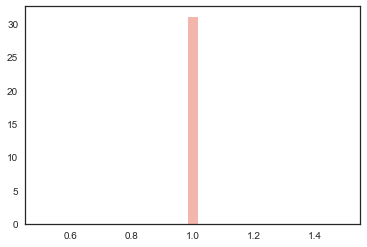

In [254]:
tmp = []
for i in range(1000):
    tmp.append(int(rand_geom(1, 2)))
sns.distplot(tmp)

In [ ]:
melted = pd.melt(hist_and_params, id_vars=['loss', 'epoch', 'runtime', 'val_loss'], var_name='param')
# melted['param'] = re.sub('\(value, |\)', '', melted['param'])
melted['param'] = melted['param'].str.replace('\(value, |\)', '')
melted

In [ ]:
sns.violinplot(x='', y=, data=hist_and_params)

In [223]:
layer_names = [x.name for x in model.layers]
layer_name = 'conv_2'
if layer_name not in layer_names:
    raise ValueError('Layer name could not be found in model')

model_truncated = Sequential()
for layer in model.layers:
    model_truncated.add(layer)
    if layer.name == layer_name:
        break

In [224]:
model.layers

In [225]:
def expand_array(a, desired_len):
    scale_factor = desired_len / len(a)
    assert scale_factor % 1 == 0, 'desired_len needs to be a multiple of the input array'
    scale_factor = int(scale_factor)
    expanded = np.empty(desired_len, dtype=type(a[0]))
    for i in range(scale_factor):
        expanded[i::scale_factor] = a
    return expanded

def get_activations(x, truncated_model):
    return truncated_model.predict(reshape_as_tensor([x]))[0].T

row = 0
series = all_data['val']['X'][row]
house_id = all_data['val']['x_house'][row]
dt = all_data['val']['x_date'][row]
print all_data['val']['Y1'][row]
print get_activations(series, model)
activations_small = get_activations(series, model_truncated)
print activations_small.shape
# activations = []
# for activation in activations_small:
#     activations.append(expand_array(activation, len(series)))

# ax.get_yaxis().set_visible(False)

[ 0.97855556  0.46715083  0.          0.77792778  0.2983925 ]
[ 0.]
(40, 1600)


In [226]:
14400/activations_small.shape[1]

9.0

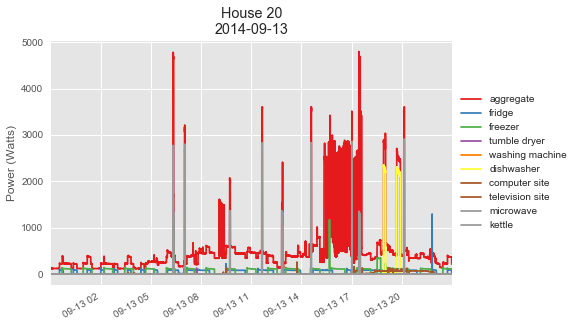

AssertionError: 

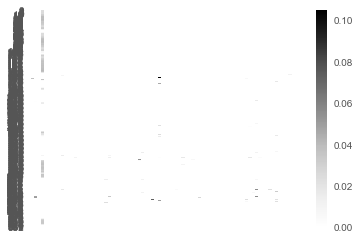

In [195]:
# Plot power series.
matplotlib.style.use('ggplot')
plot_day(house_id, date_to_datetime(dt))
plt.show()

# Plot heatmap of activations.
ax = sns.heatmap(activations_small, cmap='Greys')
ax.get_xaxis().set_visible(False)

# Plot series colored by activations.
sns.set_style('white')
plot_series_activations(series, activations_small)

matplotlib.style.use('ggplot')  # reset style

In [184]:
target_scaler = pickle.load(open(os.path.join(dir_models_set, model_name, 'target_scaler.pkl'), 'rb'))

app_idx = [APP_NAMES.index(app_name) for app_name in app_names]

Y_key = 'Y1' if target_type=='energy' else 'Y2'
mask = np.in1d(all_data['val']['x_house'], HOUSE_IDS_TEST)
for i in range(2):
    val_type = 'unseen homes' if i==0 else 'unseen days'
    X_val_fit = reshape_as_tensor(all_data['val']['X'][mask])
    Y_val_fit = target_scaler.transform(all_data['val'][Y_key][:,app_idx][mask])
    print '{}: {:0.3g}'.format(val_type, model.evaluate(X_val_fit, Y_val_fit, verbose=0))
    mask = ~mask

unseen homes: 0.297
unseen days: 0.254


In [185]:
# app_idx2 = 2
# app_idx2 = list(app_idx)
sub_app_idx = 0
if len(app_idx) == 1:
    sub_app_idx = 0
y_val = all_data['val'][Y_key][:,app_idx][:,sub_app_idx]
y_hat = target_scaler.inverse_transform(model.predict(reshape_as_tensor(all_data['val']['X']))[:,sub_app_idx])
if all(y_hat[0] == y_hat):
    print 'all predicted values are the same!'

In [72]:
# plot_series(val_data[X_idx][1])

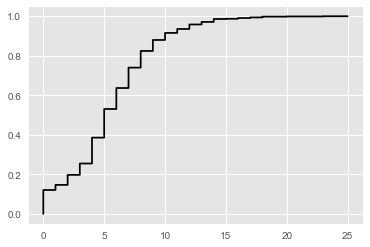

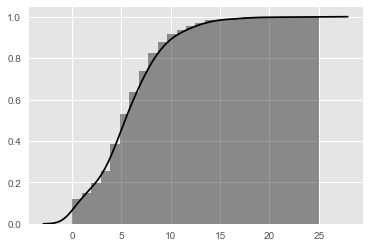

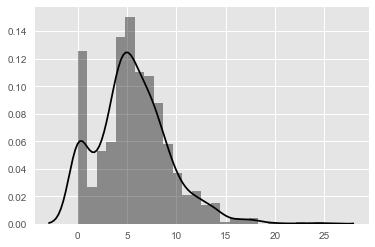

In [153]:
# sns.distplot(np.log2(y+1))
# sns.distplot(y, color='black')

value_to_plot = y_val

plot_empir_cum(value_to_plot)
plt.show()
sns.distplot(value_to_plot, color='black', hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
plt.show()
sns.distplot(value_to_plot, color='black')
plt.show()

# for i in range(Y.shape[1]):
#     ax = sns.distplot(Y[:,i], color='black')
#     ax.set_title('{}, actual'.format(APP_NAMES[i]))
#     plt.show()
#     ax = sns.distplot(Y_hat[:,i], color='black')
#     ax.set_title('{}, predicted'.format(APP_NAMES[i]))
#     plt.show() 

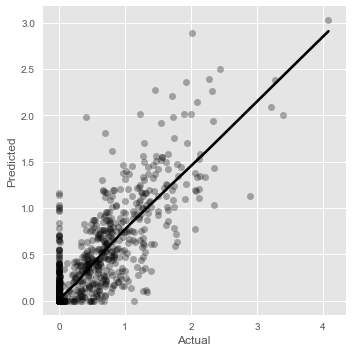

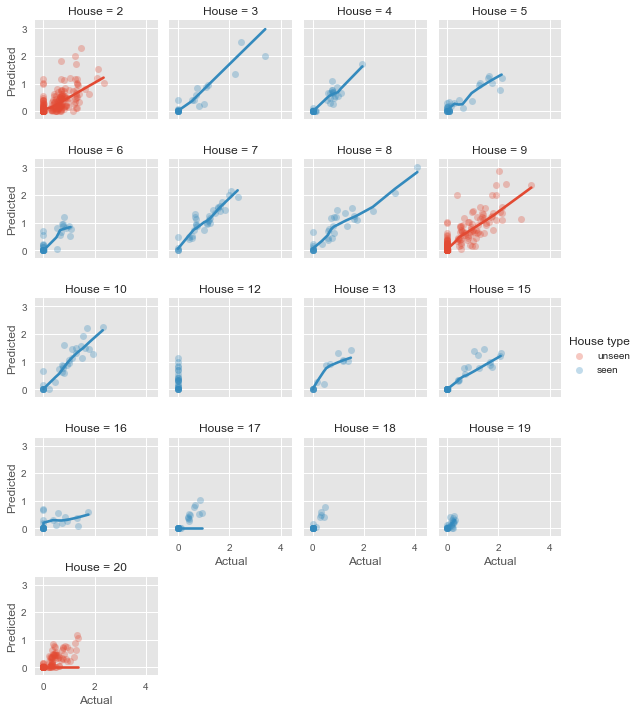

In [187]:
matplotlib.style.use('ggplot')
# sns.set_style('whitegrid')

# Plot scatter for actual vs. predicted.
lowess = True
fit_reg = True

x_house_val = all_data['val']['x_house']
plot_data = pd.DataFrame.from_dict({'Actual': y_val, 'Predicted': y_hat, 'House': x_house_val})
plot_data['House type'] = 'unseen'
plot_data.loc[plot_data['House'].isin(HOUSE_IDS_TRAIN_VAL), 'House type'] = 'seen'
# plot_data['House type'] = [str(i) for i in plot_data['House type'].values]

# plot_args = {x='Actual', y='Predicted', data=plot_data, lowess=lowess, truncate=True, fit_reg=fit_reg}
sns.lmplot(x='Actual', y='Predicted', data=plot_data, lowess=lowess, truncate=True, fit_reg=fit_reg,
           scatter_kws={'color': 'black', 'alpha': 0.3},
           line_kws={'color': 'black'})
plt.show()
sns.lmplot(x='Actual', y='Predicted', data=plot_data, lowess=lowess, truncate=True, fit_reg=fit_reg,
           scatter_kws={'alpha': 0.3},
           col='House',
           hue='House type',
           col_wrap=4,
           size=2)
plt.show()
# sns.lmplot(x='Actual', y='Predicted', data=plot_data.loc[plot_data['House type']=='seen'], lowess=lowess, truncate=True, fit_reg=fit_reg,
#            scatter_kws={'color': 'black', 'alpha': 0.3},
#            line_kws={'color': 'black'},
#            col='House',
#            col_wrap=4,
#            size=2)
# plt.show()
# sns.lmplot(x='Actual', y='Predicted', data=plot_data.loc[plot_data['House type']=='unseen'], lowess=lowess, truncate=True, fit_reg=fit_reg,
#            scatter_kws={'color': 'black', 'alpha': 0.1},
#            line_kws={'color': 'black'},
#            col='House',
#            col_wrap=4,
#            size=2)
# plt.show()

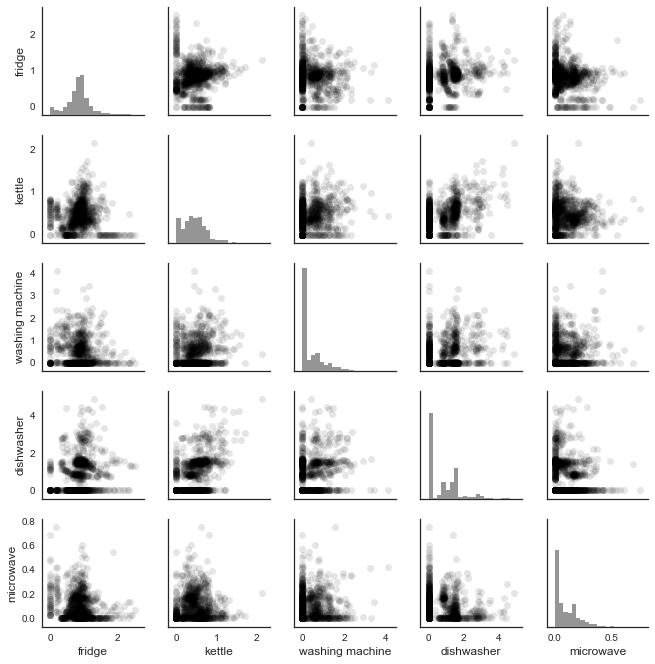

In [251]:
size = 0.75 * 2.5 # height; default 2.5
aspect = 1 # width; default 1
fit_reg = True
lowess = True

# Prepare data.
nrows = None
Y_df = pd.DataFrame(all_data['val']['Y1'][:nrows])
Y_df.columns = APP_NAMES
Y_df['House'] = all_data['val']['x_house'][:nrows]

# Create dummy variable so you're able to use palette to color
# both diag and off-diag:
# https://github.com/mwaskom/seaborn/issues/933
Y_df['Dummy'] = 1  

# Plot pairgrid.
sns.set_style('white')
g = sns.PairGrid(Y_df, vars=APP_NAMES, hue='Dummy', palette='Greys',
                 size=size,  
                 aspect=aspect)
# g = g.map_diag(sns.distplot, hist_kws={'color': 'black'}, kde_kws={'color': 'black'})
g = g.map_diag(plt.hist, bins=20)
g = g.map_offdiag(sns.regplot, color='black', scatter_kws={'alpha': 0.05}, fit_reg=fit_reg, lowess=lowess)
# g = g.map_offdiag(sns.kdeplot, cmap='Greys', shade=True, shade_lowest=False)

In [275]:
# from keras import applications

# # build the VGG16 network
# model_vgg = applications.VGG16(include_top=False,
#                            weights='imagenet')

[[469 110   0]
 [151 275   0]
 [  0   4   0]]


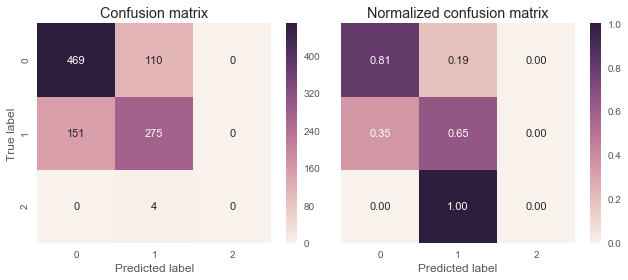

In [149]:
# Plot confusion matrix by using seaborn heatmap function
def plot_confusion_matrix(cm, normalize=False, classes=None, title='Confusion matrix'):
    """
    Credit: Data Mining and Exploration course at University of Edinburgh
    https://github.com/agamemnonc/dme/blob/master/04_Lab_4_Performance_evaluation_model_selection_solution.ipynb
    
    Plots a confusion matrix.
    
    If normalize is set to True, the rows of the confusion matrix are normalized so that they sum up to 1.
    
    """
    if normalize is True:
        cm = cm/cm.sum(axis=1)[:, np.newaxis]
        vmin, vmax = 0., 1.
        fmt = '.2f'
    else:
        vmin, vmax = None, None
        fmt = 'd'
    sns.heatmap(cm, annot=True, fmt=fmt, annot_kws={"fontsize":11}, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(np.around(y_val), np.around(y_hat))
print cm

# Your code goes here
fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(121)
plot_confusion_matrix(cm, normalize=False) # un-normalized
ax2 = fig.add_subplot(122)
plot_confusion_matrix(cm, normalize=True, title='Normalized confusion matrix') # normalized
ax2.get_yaxis().set_visible(False)
fig.tight_layout()

In [28]:
# "How convolutional neural networks see the world":
#     https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
# 

model.get_layer('conv_2')

num extreme predictions: 4
extreme prediction 0
actual energy: [ 0.395835], predicted: [ 11.80590725]


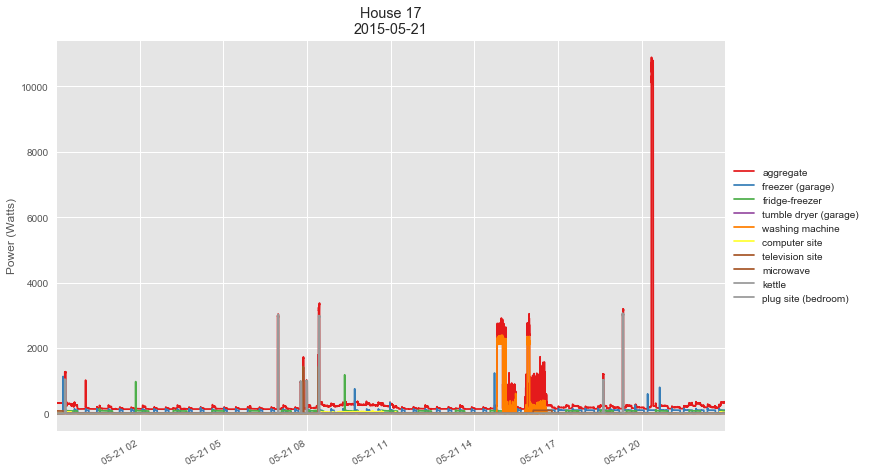

In [120]:
# Check where targets were normal but predictions were extreme.
extreme_y_hat_cutoff = 10

bad_idx = np.where(y_hat > extreme_y_hat_cutoff)[0]
print 'num extreme predictions: {}'.format(len(bad_idx))

i = 0  # change this
print 'extreme prediction {}'.format(i)

house_id = val_data[x_house_idx][bad_idx][i]
d = val_data[x_date_idx][bad_idx][i]
energy = val_data[Y_idx][:,app_idx][bad_idx][i]
print 'actual energy: {}, predicted: {}'.format(energy, y_hat[bad_idx][i])

plot_day(house_id, date_to_datetime(d), figsize=(15,8))

num extreme predictions: 2
extreme prediction 1
actual energy: [ 14.247415], predicted: [ 0.66881663]


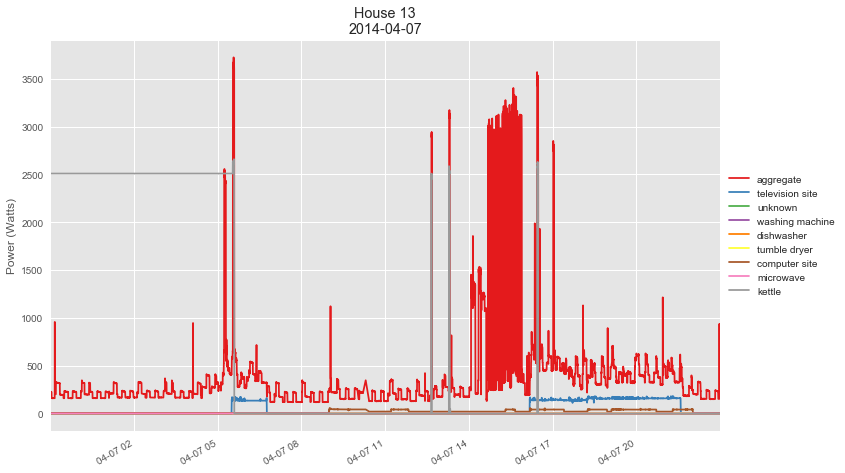

In [125]:
# Check where targets were extreme but predictions were too low.
extreme_y_cutoff = 2

bad_idx = np.where(y_val > extreme_y_cutoff)[0]
print 'num extreme predictions: {}'.format(len(bad_idx))

i = 1  # change this
print 'extreme prediction {}'.format(i)

house_id = val_data[x_house_idx][bad_idx][i]
d = val_data[x_date_idx][bad_idx][i]
energy = val_data[Y_idx][:,app_idx][bad_idx][i]
print 'actual energy: {}, predicted: {}'.format(energy, y_hat[bad_idx][i])

plot_day(house_id, date_to_datetime(d), figsize=(15,8))

In [14]:
# val_data[X_idx][0]
i = 21
app_name = 'washing machine'

app_idx = APP_NAMES.index(app_name)

plot_series(val_data[X_idx][i])
house_id = val_data[x_house_idx][i]
d = val_data[x_date_idx][i]
energy1 = val_data[Y_idx][i][app_idx]
print house_id, d, energy1

plot_day(house_id, date_to_datetime(d))
energy2 = get_energy(dstats, house_id, d, get_app_nums(house_id, app_name))
print energy2

NameError: name 'val_data' is not defined

In [18]:
# dir_proj = '/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation/thesis'
# dir_data = os.path.join(dir_proj, 'data')
# dir_for_model = os.path.join(dir_data, 'for_model')
# dir_for_model_real = os.path.join(dir_for_model, 'real')
# dir_for_model_synth = os.path.join(dir_for_model, 'synthetic')
# dir_models = os.path.join(dir_data, 'models')
# dir_run = os.path.join(dir_proj, 'run', str(date.today()))
# path_daily_stats = os.path.join(dir_data, 'stats_by_day.pkl')

# N_PER_DAY = 14400  # 24 * 60 * 60 / 6
# HOUSE_IDS = range(1, 22); HOUSE_IDS.remove(14)  # no house 14
# HOUSE_IDS_TEST = [2,9,20]
# HOUSE_IDS_TRAIN_VAL = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_TEST]
# # HOUSE_IDS_SOLAR = [3,11,21]  # according to paper
# HOUSE_IDS_SOLAR = [1,11,21]  # according to inspection
# HOUSE_IDS_NOT_SOLAR = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_SOLAR]
# # TRAIN_VAL_DATE_MAX = date(2015,2,28)
# APP_NAMES = ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']
# TRAIN_DTS = np.load(os.path.join(dir_for_model_synth, 'train_dts.npy'))

# take_diff = False
# # val_prop = 0.2
# train_dates = [dt.date() for dt in TRAIN_DTS]
# extreme_percentile_cutoff = 100



# np.random.seed(20170627)

# dstats = pd.read_pickle(path_daily_stats)
# dstats = clean_daily_stats(dstats, is_debug=False)

# all_data = prepare_real_data(dir_for_model_real,
#                              dstats,
#                              HOUSE_IDS_SOLAR,
#                              HOUSE_IDS_TRAIN_VAL,
#                              train_dates)

# all_data = prepare_synth_data(dir_for_model_synth,
#                               all_data = all_data)

# # Want to take diffs before making scalers.
# if take_diff:
#     print 'taking diffs...'
#     for key, dat in all_data.iteritems():
#         all_data[key]['X'] = take_diff_df(dat['X'])

# print 'creating scalers...'
# scaler_real, scaler_synth, scaler_both = create_scalers(all_data)

# print 'scaling validation and test data...'
# for split_type in ['val', 'test']:
#     all_data[split_type]['X'] = scaler_real.transform(all_data[split_type]['X'])
#     all_data[split_type]['X'] = scaler_both.transform(all_data[split_type]['X'])

    
params_df = pd.read_csv(os.path.join(dir_models_set, get_best_model_name(dir_models_set), 'params.csv'),
                        header=None,
                        names=['param', 'value'])

check_str_true = lambda x: x == 'True'
type_dict = {
    'num_dense_layers': int,
    'do_pool': check_str_true,
    'num_conv_layers': int,
    'learning_rate': float,
    'last_dense_layer_size': int,
    'deepen_filters': check_str_true,
    'pool_size': int,
    'dropout_rate_after_dense': float,
    'dilation_rate': int,
    'start_filters': int,
    'use_batch_norm': check_str_true,
    'strides': int,
    'dropout_rate_after_conv': float,
    'l2_penalty': float,
    'kernel_size': int,
    'hidden_layer_activation': str,
    'output_layer_activation': str,
    'loss': str
}



def static_params1():
    params = {}
    for key, value in params_df.values:
        params[key]=value
    params['hidden_layer_activation'] = 'relu'
    params['output_layer_activation'] = 'relu'
    params['loss'] = 'mse'
    params['optimizer'] = keras.optimizers.Adam
    for param_name, param_type in type_dict.iteritems():
        params[param_name] = param_type(params[param_name])
    return params

def static_params2():
    params = {}
    for key, value in params_df.values:
        params[key]=value
    params['hidden_layer_activation'] = 'relu'
    params['output_layer_activation'] = 'relu'
    params['loss'] = 'poisson'
    params['optimizer'] = keras.optimizers.Adam
    for param_name, param_type in type_dict.iteritems():
        params[param_name] = param_type(params[param_name])
    return params



today = str(date.today())
modeling_group_name = '{}_poisson'.format(today)

# run_models(
#     all_data,
#     'activations',  # 'energy' or 'activations'
#     'washing machine',
#     APP_NAMES,
#     dir_models,
#     params_function = static_params2,
#     modeling_group_name = modeling_group_name,
#     models_to_run = 1,
#     epochs = 100,
#     batch_size = 32,
#     continue_from_last_run = True,
#     total_obs_per_epoch = 8192,
#     real_to_synth_ratio = 0.5,
#     patience = 5,
#     checkpointer_verbose = 0,
#     fit_verbose = 0,
#     show_plot = False)

modeling_group_name = '{}_not_poisson'.format(today)

run_models(
    all_data,
    'activations',  # 'energy' or 'activations'
    'washing machine',
    APP_NAMES,
    dir_models,
    params_function = static_params1,
    modeling_group_name = modeling_group_name,
    models_to_run = 1,
    epochs = 100,
    batch_size = 32,
    continue_from_last_run = True,
    total_obs_per_epoch = 8192,
    real_to_synth_ratio = 0.5,
    patience = 5,
    checkpointer_verbose = 0,
    fit_verbose = 0,
    show_plot = False)

model_3
                                                        0
loss                                                  mse
hidden_layer_activation                              relu
output_layer_activation                              relu
optimizer                 <class 'keras.optimizers.Adam'>
num_dense_layers                                        1
do_pool                                              True
num_conv_layers                                         4
learning_rate                                       0.001
last_dense_layer_size                                  32
deepen_filters                                       True
pool_size                                               4
dropout_rate_after_dense                             0.25
dilation_rate                                           1
start_filters                                           4
use_batch_norm                                      False
strides                                                 1
dropou

/Users/sipola/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


shuffling...
scaling real data...
scaling synthetic data...
scaling real and synthetic data jointly...
scaling targets for both real and synth...


In [622]:
for layer in model.layers:
    print '{}'.format(layer.name)
    try:
        print layer.output
    except AttributeError:
        pass

conv_0
Tensor("conv_0_25/Relu:0", shape=(?, 7200, 4), dtype=float32)
pool_0
conv_1
pool_1
conv_2
pool_2
conv_3
pool_3
dropout_after_conv
flatten
dense_0
dropout_dense_0
dense_1
dropout_dense_1
dense_output


In [669]:
def create_model(
    num_outputs,
    n_per_day,
    num_conv_layers,
    num_dense_layers,
    start_filters,
    deepen_filters,
    kernel_size,
    strides,
    dilation_rate,
    do_pool,
    pool_size,
    last_dense_layer_size,
    dropout_rate_after_conv,
    dropout_rate_after_dense,
    use_batch_norm,
    optimizer,
    learning_rate,
    l2_penalty,
    hidden_layer_activation,
    output_layer_activation,
    loss,
    print_layers=False
):
    
    if dilation_rate > 1:
        # Make dilation rate override stride length.
        strides = 1
    
    if strides > kernel_size:
        strides = kernel_size
    
    if not do_pool:
        pool_size = None
        
    if num_dense_layers == 0:
        last_dense_layer_size == None
        
    assert not (dilation_rate != 1 and strides != 1)

    kernel_regularizer = regularizers.l2(l2_penalty)
    input_shape = (n_per_day, 1) if K.image_data_format() == 'channels_last' else (1, n_per_day)

    model = Sequential()
    
    # Add convolutional layers.
    for layer_num in range(num_conv_layers):
        
        filter_multiplier = 2**layer_num if deepen_filters else 1
        filters = start_filters * filter_multiplier
        
        conv_args = {'filters': filters,
                     'kernel_size': kernel_size,
                     'strides': strides,
                     'padding': 'same',
                     'dilation_rate': dilation_rate,
                     'activation': hidden_layer_activation,
                     'name': 'conv_{}'.format(layer_num),
                     'kernel_regularizer': kernel_regularizer}
        if layer_num == 0:
            # Need input shape if first layer.
            conv_args['input_shape'] = input_shape
        
        model.add(Conv1D(**conv_args))
        
        if do_pool:
            model.add(MaxPooling1D(pool_size, padding='same', name='pool_{}'.format(layer_num)))
    
    model.add(Dropout(dropout_rate_after_conv, name='dropout_after_conv'))
    model.add(Flatten(name='flatten'))
    
    # Add dense layers.
    for layer_num in range(num_dense_layers):
        layer_size = last_dense_layer_size * 2**(num_dense_layers - layer_num - 1)
        model.add(Dense(layer_size, activation=hidden_layer_activation,
                        kernel_regularizer=kernel_regularizer, name='dense_{}'.format(layer_num)))
        model.add(Dropout(dropout_rate_after_dense, name='dropout_dense_{}'.format(layer_num)))
        if use_batch_norm:
            model.add(BatchNormalization(name='batch_norm_{}'.format(layer_num)))
    
    model.add(Dense(num_outputs, activation=output_layer_activation, name='dense_output',
                    kernel_regularizer=kernel_regularizer))
    
    model.compile(loss=loss,
                  # optimizer='adam',
                  optimizer = optimizer(lr=learning_rate),
                  metrics=None)
    
    def print_layers(model):
        shape_pattern = 'shape=(.+?), dtype'
            for layer in model.layers:
                print '{}: {}'.format(layer.name, re.search(shape_pattern, str(layer.output)).group(1))
    if print_layers:
        
    
    return model


def static_params():
    return {
    'num_conv_layers': 6,
    'num_dense_layers': 2,
    'start_filters': 8,
    'deepen_filters': True,
    'kernel_size': 6,
    'strides': 2,
    'dilation_rate': 1,
    'do_pool': True,
    'pool_size': 2,
    'last_dense_layer_size': 16,
    'dropout_rate_after_conv': 0.5,
    'dropout_rate_after_dense': 0.25,
    'use_batch_norm': False,
    'optimizer': keras.optimizers.Adam,
    'learning_rate': 0.0001,
    'l2_penalty': 0,
    'hidden_layer_activation': 'elu',
    'output_layer_activation': 'relu',
    'loss': 'mse'
    }
        
create_model(1, 14400, print_layers=True, **static_params())

conv_0: (?, 7200, 8)
pool_0: (?, 3600, 8)
conv_1: (?, 1800, 16)
pool_1: (?, 900, 16)
conv_2: (?, 450, 32)
pool_2: (?, 225, 32)
conv_3: (?, 113, 64)
pool_3: (?, 57, 64)
conv_4: (?, 29, 128)
pool_4: (?, 15, 128)
conv_5: (?, 8, 256)
pool_5: (?, 4, 256)
dropout_after_conv: (?, 4, 256)
flatten: (?, ?)
dense_0: (?, 32)
dropout_dense_0: (?, 32)
dense_1: (?, 16)
dropout_dense_1: (?, 16)
dense_output: (?, 1)


In [666]:
shape_pattern = 'shape=(.+?), dtype'
m = re.search(shape_pattern, )
m.group(1)

'(?, 1)'